In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from bosonStar import *
from util import *

from ctypes import *
file = "./testing.so"
my_func = CDLL(file)

#Middle
massInCU = 2e-77
aInCU = 1e-74
totalMassInCU = 0.1
#dtInCU = 1000.0
#bigT = 100000
dtInCU = 1000.0
bigT = 10000

/home/kklee/anaconda3/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


A2=  -0.3197640202007044  X= 20.65212130424261
A2=  -0.5697373699270627  X= 11.607863215726432
A2=  -0.6028590361462758  X= 13.777627555255112
A2=  -0.5942834565443862  X= 21.55988311976624
A2=  -0.5960027836395483  X= 15.624271248542499
A2=  -0.5961968711195593  X= 31.49742299484599
A2=  -0.596193397073232  X= 21.4244428488857
A2=  -0.596193397073232  X= 21.4244428488857
MU= 0.044043768643244496 MASS= 0.09999684012922637
FAR POINT: 143902 500000


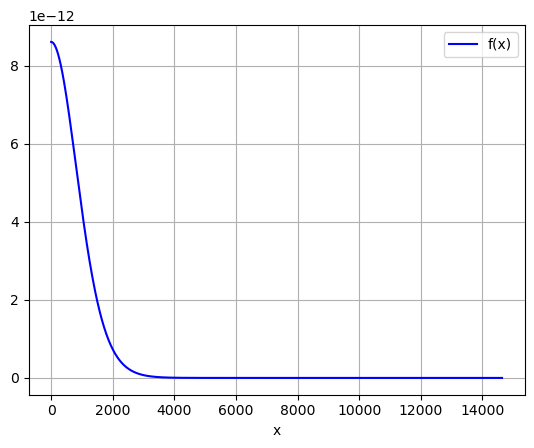

(1000,)


In [2]:
bosonStar = outputProfile(massInCU, aInCU, totalMassInCU, 500)
x = bosonStar["x"]
psi = bosonStar["profile"]

dx = x[1]-x[0]
for i in range(500):
    x = np.append(x, x[-1]+dx)
    psi = np.append(psi, psi[-1])

print(x.shape)

In [3]:
totalMass = massSIToPlanckUnit(massCodeUnitToSI(totalMassInCU))
m = massSIToPlanckUnit(massCodeUnitToSI(massInCU))
a = lengthSIToPlanckUnit(lengthCodeUnitToSI(aInCU))
N = totalMass/m
Ra = np.sqrt(a/m/m/m)
omegaA = m*m/np.abs(a)
epsilon = 1.0/omegaA/m/Ra/Ra
a0 = np.sqrt(1.0/omegaA/m)
delta = 4.0*np.pi*a*N/a0
GM = totalMass/Ra/Ra/Ra/omegaA/omegaA

print("R:", Ra)
print("Omega:" ,omegaA)
print("Epsilon (Should be 1):", epsilon)
print("Delta:", delta)
print("New G:", GM)

R: 1.2233182200635002e+40
Omega: 3.6561290929984644e-42
Epsilon (Should be 1): 1.0
Delta: 4.692649123249829
New G: 0.3734291520805296


In [4]:
x = lengthSIToPlanckUnit(lengthCodeUnitToSI(x))/Ra
psi = np.sqrt(densitySIToPlanckUnit(densityCodeUnitToSI(psi))/totalMass)*np.power(Ra, 3.0/2.0)
normalization = scipy.integrate.simpson(4.0*np.pi*x*x*np.absolute(psi)*np.absolute(psi), x=x)
psi = psi/normalization
psi = psi.astype(complex)

size = len(psi)
dt = timeSIToPlanckUnit(timeCodeUnitToSI(dtInCU))*omegaA
dx = x[1]-x[0]

print(psi)
print("DT:", dt)
print("DX:", dx)

[1.43747345e-02+0.j 1.43657027e-02+0.j 1.43476610e-02+0.j
 1.43206532e-02+0.j 1.42847448e-02+0.j 1.42400227e-02+0.j
 1.41865943e-02+0.j 1.41245877e-02+0.j 1.40541506e-02+0.j
 1.39754496e-02+0.j 1.38886694e-02+0.j 1.37940121e-02+0.j
 1.36916960e-02+0.j 1.35819548e-02+0.j 1.34650361e-02+0.j
 1.33412009e-02+0.j 1.32107219e-02+0.j 1.30738822e-02+0.j
 1.29309748e-02+0.j 1.27823006e-02+0.j 1.26281675e-02+0.j
 1.24688891e-02+0.j 1.23047835e-02+0.j 1.21361720e-02+0.j
 1.19633781e-02+0.j 1.17867259e-02+0.j 1.16065396e-02+0.j
 1.14231419e-02+0.j 1.12368533e-02+0.j 1.10479908e-02+0.j
 1.08568674e-02+0.j 1.06637908e-02+0.j 1.04690629e-02+0.j
 1.02729790e-02+0.j 1.00758269e-02+0.j 9.87788664e-03+0.j
 9.67942967e-03+0.j 9.48071850e-03+0.j 9.28200624e-03+0.j
 9.08353625e-03+0.j 8.88554182e-03+0.j 8.68824597e-03+0.j
 8.49186122e-03+0.j 8.29658950e-03+0.j 8.10262202e-03+0.j
 7.91013931e-03+0.j 7.71931116e-03+0.j 7.53029674e-03+0.j
 7.34324463e-03+0.j 7.15829303e-03+0.j 6.97556986e-03+0.j
 6.79519298e-0

In [5]:
T = np.zeros((size,size)).astype(complex)
TSph = np.zeros((size,size)).astype(complex)
Q = np.zeros((size,size)).astype(complex)
V2Grav = np.zeros((size,size)).astype(complex)
I = np.identity(size).astype(complex)
phi = np.zeros((size))

In [6]:
def setupT():
    global T, TSph
    for i in range(size):
        if i==0:
            T[i][i] = (4.0/3.0-5.0/2.0)*3
            T[i][i+1] = (4.0/3.0-1.0/12.0)*3
            T[i][i+2] = (-1.0/12.0)*3
        elif i==1:
            T[i][i-1] = (-1.0/12.0+4.0/3.0)*3
            T[i][i] = (-5.0/2.0)*3
            T[i][i+1] = (4.0/3.0)*3
            T[i][i+2] = (-1.0/12.0)*3
        elif i==size-1:
            T[i][i-2] = -1.0/12.0
            T[i][i-1] = 4.0/3.0
            T[i][i] = -5.0/2.0+4.0/3.0-1.0/12.0
            #TSph[i][i-1] = -1.0/2.0/x[i]
            #TSph[i][i] = 1.0/2.0/x[i]
            TSph[i][i-2] = 1.0/12.0/x[i]
            TSph[i][i-1] = -2.0/3.0/x[i]
            TSph[i][i] = (2.0/3.0 - 1.0/12.0)/x[i]
        elif i==size-2:
            T[i][i-2] = -1.0/12.0
            T[i][i-1] = 4.0/3.0
            T[i][i] = -5.0/2.0
            T[i][i+1] = 4.0/3.0-1.0/12.0
            #TSph[i][i+1] = 1.0/2.0/x[i]
            #TSph[i][i-1] = -1.0/2.0/x[i]
            TSph[i][i-2] = 1.0/12.0/x[i]
            TSph[i][i-1] = -2.0/3.0/x[i]
            TSph[i][i+1] = (2.0/3.0 - 1.0/12.0)/x[i]
        else:
            T[i][i-2] = -1.0/12.0
            T[i][i-1] = 4.0/3.0
            T[i][i] = -5.0/2.0
            T[i][i+1] = 4.0/3.0
            T[i][i+2] = -1.0/12.0
            #TSph[i][i+1] = 1.0/2.0/x[i]
            #TSph[i][i-1] = -1.0/2.0/x[i]
            TSph[i][i-2] = 1.0/12.0/x[i]
            TSph[i][i-1] = -2.0/3.0/x[i]
            TSph[i][i+1] = 2.0/3.0/x[i]
            TSph[i][i+2] = -1.0/12.0/x[i]

    T = -1.0/2.0/dx/dx*T
    TSph = -1.0/dx*TSph

def setupQ():
    global Q
    for i in range(size):
        Q[i][i] = delta*np.absolute(psi[i])*np.absolute(psi[i])

def setupV2Grav():
    global V2Grav, phi, psi

    rho = np.absolute(psi)*np.absolute(psi)
    rho_c = (c_double * size)(*rho)
    phi_c = (c_double * size)(*np.absolute(phi))
    my_func.findGravRho(rho_c, phi_c, c_int(size), c_double(dx))
    for i in range(size):
        phi[i] = phi_c[i] * GM

    for i in range(size):
        V2Grav[i][i] = phi[i]

def setupU1U2():
    global U1, U2
    U1 = I + 1.0j*dt/2.0*(T+TSph+Q+V2Grav)
    U2 = I - 1.0j*dt/2.0*(T+TSph+Q+V2Grav)

0 0.0 0.014374792970969105 1.0000606815098654
1 0.3340410855163411 0.01437492094538314 1.0000606809261503
2 0.6680821710326822 0.014375104807756152 1.0000606816672226
3 1.0021232565490232 0.014375385979303575 1.0000606806672627
4 1.3361643420653644 0.014375731231983775 1.0000606816701685
5 1.6702054275817055 0.014376160290549335 1.0000606804773269
6 2.0042465130980465 0.01437666299369288 1.0000606814920894
7 2.3382875986143876 0.014377243741519668 1.0000606803774283
8 2.6723286841307288 0.014377899306283968 1.0000606811153194
9 3.00636976964707 0.014378593015196037 1.0000606803754264
10 3.340410855163411 0.014379282733235466 1.0000606805828591
11 3.6744519406797522 0.014379970703541446 1.0000606804765333
12 4.008493026196093 0.014380654161732712 1.0000606799747431
13 4.3425341117124345 0.014381334391152176 1.000060680623657
14 4.676575197228775 0.014382010017533907 1.000060679365174
15 5.010616282745117 0.014382680734500015 1.0000606807370256
16 5.3446573682614575 0.014383346925318272 

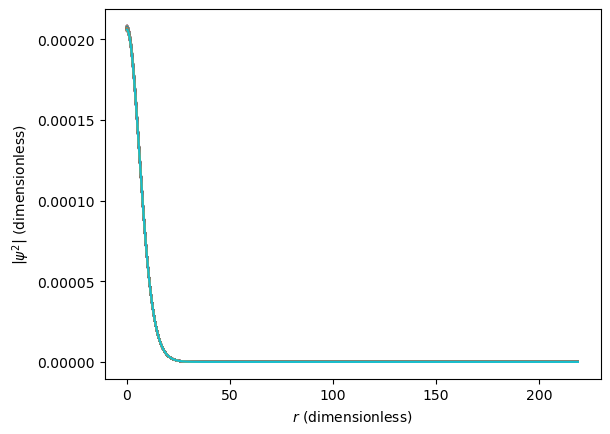

In [7]:
setupT()
setupQ()
setupV2Grav()
setupU1U2()

#Record
hello = []
hello2 = []
gravitationalForce = []
pressureGradient = []
quantumPressure = []

ts = []
oldGM = GM
newGM = GM*1.1
for t in range(bigT):
    #Pertubation
    if(t*dt<3.0):
        GM = newGM
    if(t*dt>=3.0):
        GM = oldGM

    setupT()
    setupQ()
    setupV2Grav()
    setupU1U2()
    psi = np.linalg.solve(U2, np.dot(U1,psi))

    normalization = scipy.integrate.simpson(4.0*np.pi*x*x*np.absolute(psi)*np.absolute(psi), x=x)
    #if(normalization >= 1.01):
    #    break
    print(t, t*dt, np.absolute(psi[0]), normalization)
    if(GM == oldGM):

        #Record
        rho0 = (np.absolute(psi[14])*np.absolute(psi[14]))/Ra/Ra/Ra*totalMass
        rho1 = (np.absolute(psi[15])*np.absolute(psi[15]))/Ra/Ra/Ra*totalMass
        rho2 = (np.absolute(psi[16])*np.absolute(psi[16]))/Ra/Ra/Ra*totalMass
        rho3 = (np.absolute(psi[17])*np.absolute(psi[17]))/Ra/Ra/Ra*totalMass
        Q0 = -((np.sqrt(rho0) -2*np.sqrt(rho1) + np.sqrt(rho2))/(dx*Ra)/(dx*Ra) + 2.0/(x[15]*Ra)*(np.sqrt(rho1)-np.sqrt(rho0))/(dx*Ra))/np.sqrt(rho1)/2.0/m
        Q1 = -((np.sqrt(rho1) -2*np.sqrt(rho2) + np.sqrt(rho3))/(dx*Ra)/(dx*Ra) + 2.0/(x[16]*Ra)*(np.sqrt(rho2)-np.sqrt(rho1))/(dx*Ra))/np.sqrt(rho2)/2.0/m

        gravitationalForce.append((phi[16]-phi[15])/dx)
        pressureGradient.append(4.0*np.pi*a/m/m/m*(rho2-rho1)/(dx*Ra)/Ra/omegaA/omegaA)
        quantumPressure.append((Q1-Q0)/m/(dx*Ra)/Ra/omegaA/omegaA)

        def findMass():
            for i in range(size):
                if(i != 0):
                    temp = scipy.integrate.simpson(4.0*np.pi*x[:i]*x[:i]*np.absolute(psi[:i])*np.absolute(psi[:i]), x=x[:i])
                    if(temp > 0.99):
                        return i
            return size-1
            
        hello2.append(findMass())

        hello.append(np.absolute(psi[0])*np.absolute(psi[0]))
        ts.append(t*dt)

    if t%100 == 0:
        '''
        hBarInCU = 1.1977151493389159e-76
        setupV2Grav()
        np.set_printoptions(threshold=np.inf)

        rhoTemp = np.absolute(psi)*np.absolute(psi)/Ra/Ra/Ra*totalMass*5.1550e96*0.001*1.619e-18
        pressure = 2.0*np.pi*aInCU*hBarInCU*hBarInCU/massInCU/massInCU/massInCU*rhoTemp*rhoTemp
        pressureGradients = np.gradient(pressure, x*Ra*1.616e-35*100*6.77193e-6, edge_order=2)
        gravitationalPotential = phi*Ra*Ra*omegaA*omegaA*1.616e-35*100*6.77193e-6*1.616e-35*100*6.77193e-6/5.391e-44/5.391e-44/2.03017e5/2.03017e5

        dRhodx = np.gradient(np.sqrt(rhoTemp), x*Ra*1.616e-35*100*6.77193e-6, edge_order=2)
        d2Rhodx = np.gradient(dRhodx, x*Ra*1.616e-35*100*6.77193e-6, edge_order=2)
        quantumPotential = -hBarCU*hBarCU/2.0/massInCU*(d2Rhodx + 2.0/(x*Ra*1.616e-35*100*6.77193e-6)*dRhodx)/np.sqrt(rhoTemp)

        plt.plot(x*Ra*1.616e-35*100*6.77193e-6, pressureGradients/rhoTemp)
        plt.plot(x*Ra*1.616e-35*100*6.77193e-6, np.gradient(gravitationalPotential, x*Ra*1.616e-35*100*6.77193e-6, edge_order=2))
        plt.plot(x*Ra*1.616e-35*100*6.77193e-6, np.gradient(quantumPotential, x*Ra*1.616e-35*100*6.77193e-6)/massInCU)

        plt.xlim(0.0,10000.0)
        plt.ylim(-3e-8,3e-8)
        #print(np.gradient(quantumPotential[100:1500], x[100:1500]*Ra*1.616e-35*100*6.77193e-6)/massInCU)
        #print(x[100]*Ra*1.616e-35*100*6.77193e-6)
        plt.show()
        '''

        plt.plot(x, np.absolute(psi)*np.absolute(psi))

plt.xlabel(r"$r$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

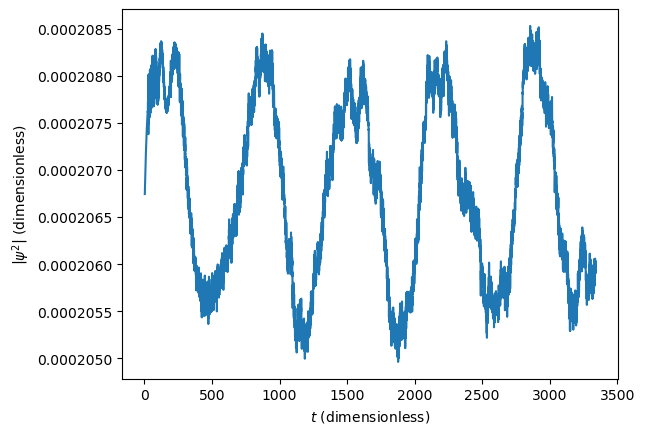

In [8]:
plt.plot(ts, hello)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

Text(0.5, 0, 'f (1/s)')

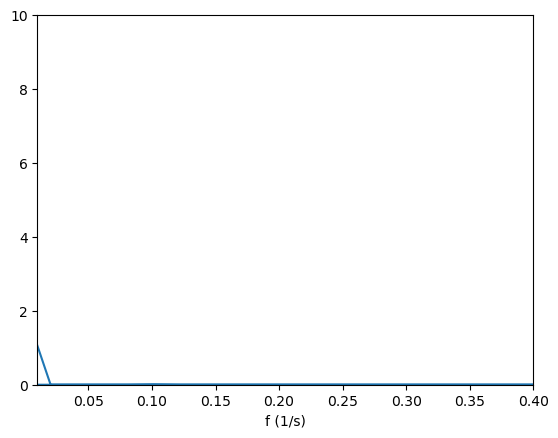

In [9]:
sp = np.fft.fft(hello)
freq = np.fft.fftfreq(len(hello), d=dt)*omegaA/5.391247e-44

plt.plot(freq, np.absolute(sp))
plt.xlim(0.01,0.4)
plt.ylim(0.0,10.0)
plt.xlabel("f (1/s)")

In [10]:
print(freq[1]-freq[0])
for i in range(len(freq)-1):
    if(freq[i] > 0.0 and np.absolute(sp[i]) > 0.04 and np.absolute(sp[i])>np.absolute(sp[i+1]) and np.absolute(sp[i])>np.absolute(sp[i-1])):
        print(freq[i], np.absolute(sp[i]))

0.020319987989190266


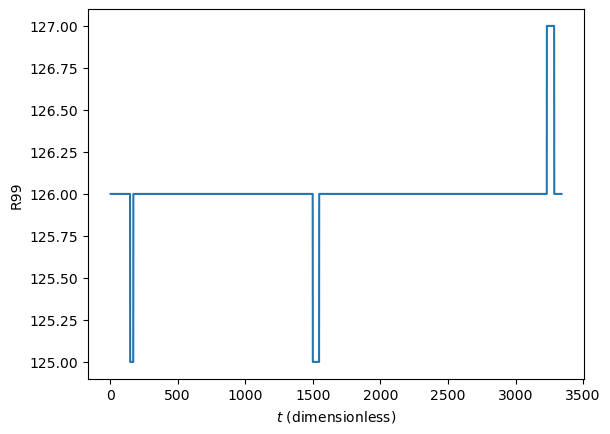

In [11]:
plt.plot(ts, hello2)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"R99")
plt.show()

Text(0.5, 0, 'f (1/s)')

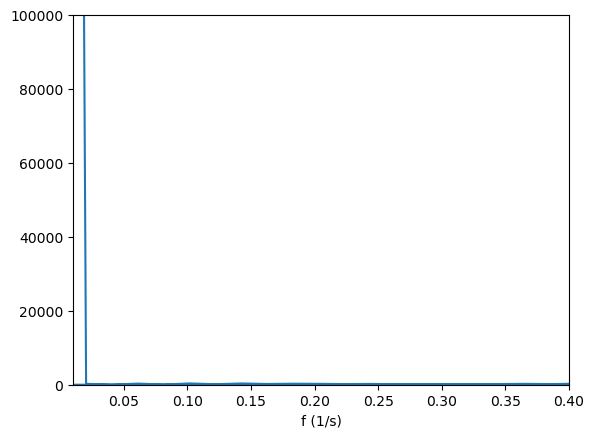

In [12]:
sp = np.fft.fft(hello2)
freq = np.fft.fftfreq(len(hello2), d=dt)*omegaA/5.391247e-44

plt.plot(freq, np.absolute(sp))
plt.xlim(0.01,0.4)
plt.ylim(0.0,100000)
plt.xlabel("f (1/s)")

In [13]:
print(freq[1]-freq[0])
for i in range(len(freq)-1):
    if(freq[i] > 0.0 and np.absolute(sp[i]) > 5000 and np.absolute(sp[i])>np.absolute(sp[i+1]) and np.absolute(sp[i])>np.absolute(sp[i-1])):
        print(freq[i], np.absolute(sp[i]))

0.020319987989190266


[1.43528393e-02 1.43431189e-02 1.43243751e-02 1.42979524e-02
 1.42615392e-02 1.42160883e-02 1.41633235e-02 1.41012148e-02
 1.40313589e-02 1.39531036e-02 1.38667932e-02 1.37721298e-02
 1.36701372e-02 1.35603717e-02 1.34440565e-02 1.33207523e-02
 1.31907632e-02 1.30543915e-02 1.29119829e-02 1.27636593e-02
 1.26099786e-02 1.24512637e-02 1.22875642e-02 1.21194899e-02
 1.19472486e-02 1.17713677e-02 1.15917109e-02 1.14088935e-02
 1.12231917e-02 1.10350537e-02 1.08444782e-02 1.06520994e-02
 1.04579530e-02 1.02625200e-02 1.00661276e-02 9.86891243e-03
 9.67103945e-03 9.47289440e-03 9.27470641e-03 9.07673363e-03
 8.87927312e-03 8.68231605e-03 8.48637775e-03 8.29160685e-03
 8.09806022e-03 7.90598670e-03 7.71574745e-03 7.52714837e-03
 7.34046981e-03 7.15592484e-03 6.97357343e-03 6.79353459e-03
 6.61596069e-03 6.44089351e-03 6.26851119e-03 6.09886901e-03
 5.93193851e-03 5.76788165e-03 5.60674250e-03 5.44853302e-03
 5.29335405e-03 5.14118064e-03 4.99197988e-03 4.84583332e-03
 4.70280196e-03 4.562800

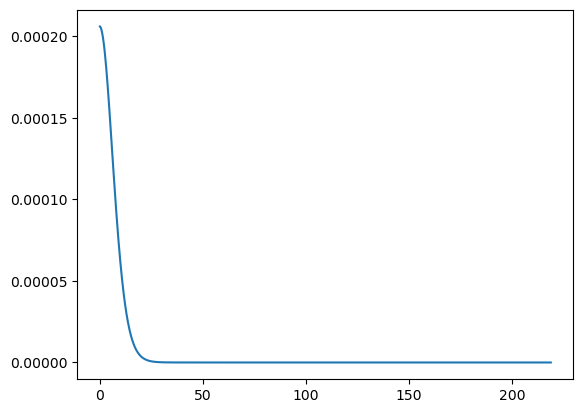

In [14]:
plt.plot(x, np.absolute(psi)*np.absolute(psi))
print(np.absolute(psi))

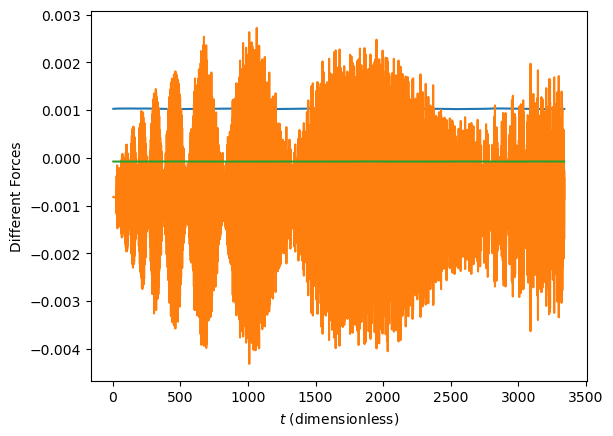

In [15]:
'''
sp = np.fft.fft(quantumPressure)
freq = np.fft.fftfreq(len(quantumPressure), d=dt)*omegaA/5.391247e-44

for i in range(len(freq)):
    if(freq[i]<=-10.0 or freq[i]>=10.0):
        sp[i] = 0.0

quantumPressure = np.fft.ifft(sp)
'''

plt.plot(ts, gravitationalForce)
plt.plot(ts, quantumPressure)
plt.plot(ts, pressureGradient)
#plt.plot(ts, gravitationalForce+pressureGradient)
#plt.plot(ts, gravitationalForce+quantumPressure)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"Different Forces")
plt.show()

/home/kklee/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/kklee/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


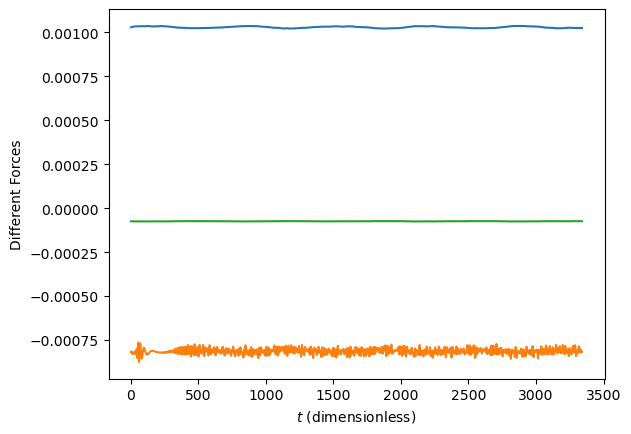

In [16]:
sp = np.fft.fft(quantumPressure)
freq = np.fft.fftfreq(len(quantumPressure), d=dt)*omegaA/5.391247e-44

for i in range(len(freq)):
    if(freq[i]<=-10.0 or freq[i]>=10.0):
        sp[i] = 0.0

quantumPressure = np.fft.ifft(sp)

plt.plot(ts, gravitationalForce)
plt.plot(ts, quantumPressure)
plt.plot(ts, pressureGradient)
#plt.plot(ts, gravitationalForce+pressureGradient)
#plt.plot(ts, gravitationalForce+quantumPressure)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"Different Forces")
plt.show()

Middle
0.071-0.081			M1 (M2: 0.142-0.162, M3: 0.213-0.243, M4: 0.284-0.324, M5: 0.355-0.405)
0.132-0.137			M1?
0.158-0.163			M2
0.193-0.204			M1?
0.239-0.249			M3
0.295-0.305			M4
0.361-0.371			M5

0.076-0.086			M1
0.132-0.142			M1?
0.158-0.168			M2

Small
0.097-0.107		M1
0.163-0.173		M1?
0.214-0.224		M2
0.270-0.280		M1?
0.341-0.351		M3
0.432-0.443		M4
0.534-0.544		M5
0.651-0.661		M6

Heavy
0.031-0.037		M1
0.058-0.065		M2
0.072-0.078		M?
0.082-0.089		M?
0.099-0.167 	M3
0.116-0.123		M4
0.140-0.147		M5
0.167-0.173		M6?
0.194-0.201 	M7?